__Change current directory__

In [1]:
import os
os.chdir('..')

### Import libraries and modules

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from timeit import default_timer
import pandas as pd
import seaborn as sns
from src import detector_descriptor as dd
from src import data as dt
from src import util
from src import experiments as ex
from src import imgop as ip
import yaml
plt.style.use('fast')


__Load configuration__

In [3]:
with open(os.path.join('./', 'config.yml'), 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)
    cfg = cfg['default']

__Load image set__

In [4]:
dataset_path = cfg['dataset']['pckl_path']
dataset_pckl_name = cfg['dataset']['dataset_type']['oxford']['pckl_name']
pckl_path = os.path.join(dataset_path, dataset_pckl_name)

#### Image set to variance

In [5]:
image_set_variance = {
    'bark': 'zoom_rotation', 
    'boat': 'zoom_rotation',
    'leuven': 'light',
    'bikes': 'blur', 
    'trees': 'blur',
    'wall': 'viewpoint',
    'graf': 'viewpoint',
    'ubc': 'jpeg-compression'
}



##### Show all images from an image set

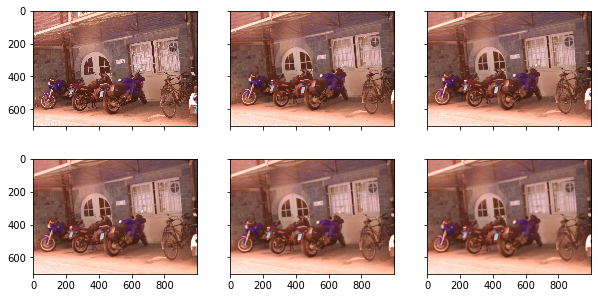

In [6]:
# all_detectors = dd.get_all_detectors()
# print(list(all_detectors.keys()))
image_set = util.get_image_set(pckl_path, 'bikes')
util.show_image_set(image_set)

### First experiment
Visualize total number of keypoints vs execution time for corresponding detectors

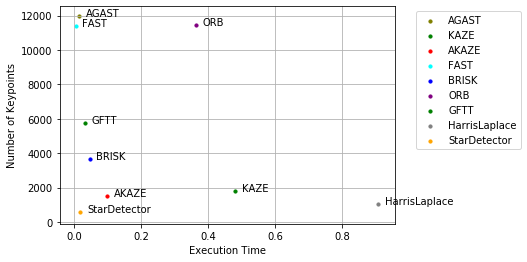

In [7]:
image_set_ = util.get_image_set(pckl_path, 'bikes')
image_num = 1
image = image_set_['{0}_img{1}'.format('bikes', image_num)]
ex.experiment_1_plt(image)

Number of total keypoints and execution time for each detector type for an image

In [8]:
image_set_name = 'bikes'
image_set_ = util.get_image_set(pckl_path, image_set_name)
image_num = 4
image = image_set_['{0}_img{1}'.format(image_set_name, image_num)]
df = ex.experiment_1_df(image)
df.style. \
    apply(util.highlight_max, subset=['Execution Time', 'Number of Keypoints']). \
    apply(util.highlight_min, subset=['Execution Time', 'Number of Keypoints'])


,Detector,Execution Time,Number of Keypoints
0,AGAST,0.005013,1115
1,KAZE,0.462047,928
2,AKAZE,0.094113,970
3,FAST,0.001193,1039
4,BRISK,0.016466,561
5,ORB,0.006260,2196
6,GFTT,0.031221,8020
7,HarrisLaplace,0.861315,376
8,StarDetector,0.018480,175


#### Visualize average total number of keypoints vs average execution time for corresponding detectors for a certain image set

In [9]:
image_set_arr = ['leuven', 'bikes', 'ubc']
plot_data_arr = []

for image_set_name in image_set_arr: 
    image_set = util.get_image_set(pckl_path, image_set_name)
    avg_execution_time, avg_total_keypoints = ip.get_det_avg_numkp_et(image_set)
    plot_data = {}
    for name in avg_execution_time.keys():
        plot_data[name] = [avg_execution_time[name], avg_total_keypoints[name]]
    plot_data_arr.append(plot_data)

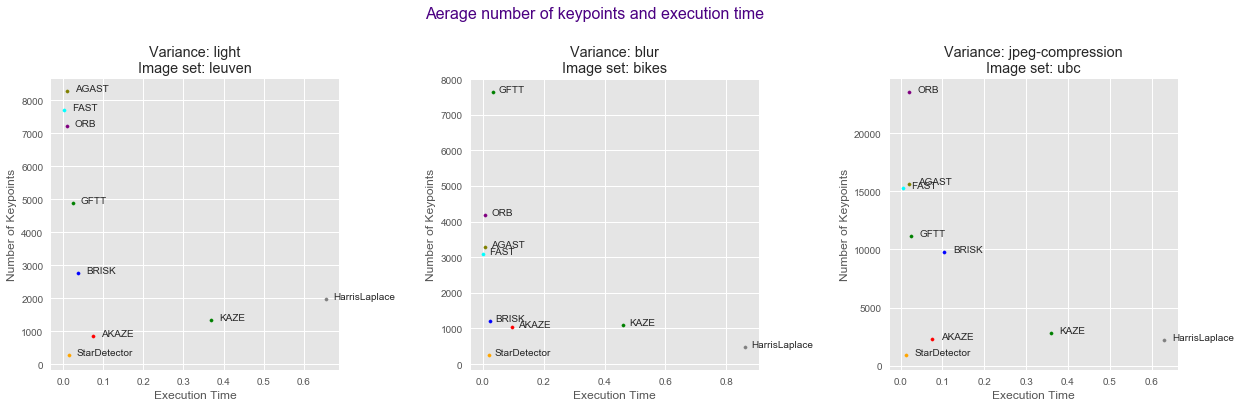

In [30]:
# sns.set_style("darkgrid")
plt.style.use('ggplot')

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
colors = ['olive', 'green', 'red', 'cyan', 'blue', 'purple', 'green', 'grey', 'orange', 'brown']

plot_data_index = 0
for plot_data in plot_data_arr:
    color_index = 0
    for key, values in plot_data.items():
        x, y = values
        axs[plot_data_index].scatter(x, y, c=colors[color_index], s=10, label=key)
        axs[plot_data_index].annotate(key, xy=(x+0.02, y), textcoords='data')
        color_index += 1
    axs[plot_data_index].grid(True)
    # axs[1].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    axs[plot_data_index].set_xlabel("Execution Time")
    axs[plot_data_index].set_ylabel("Number of Keypoints")
    variance = image_set_variance[image_set_arr[plot_data_index]]
    image_set_name = image_set_arr[plot_data_index]
    axs[plot_data_index].set_title(f"Variance: {variance}\nImage set: {image_set_name}")
    plot_data_index += 1
fig.subplots_adjust(wspace = 0.45)
plt.suptitle('Aerage number of keypoints and execution time', fontsize = 16, y = 1.08, color='indigo')
plt.show()

#### Gradual blurring
The runtime and number of keypoints detected as the image is progressively blurred
##### Observations:
- Harris Laplace has the highest runtime 0.85 seconds. KAZE has a runtime of ~0.45s and the rest falls wihtin a very close range ~0.001 to ~0.03 
- All the detectors trends downward while only GFTT detects more keypoints for the 'bikes' image set.

In [45]:
image_set_arr = ['leuven', 'trees', 'ubc']
plot_data_arr = []

for image_set_name in image_set_arr: 
    image_set = util.get_image_set(pckl_path, image_set_name)  
    plot_data = {}
    for detector_name in dd.get_all_detectors().keys():    
#     if detector_name in ['FAST', 'AGAST']:
#         continue
#         execution_time, total_keypoints 
        plot_data[detector_name]= ip.get_det_kp_et(image_set, detector_name)
    plot_data_arr.append(plot_data)
print(len(plot_data_arr))

3


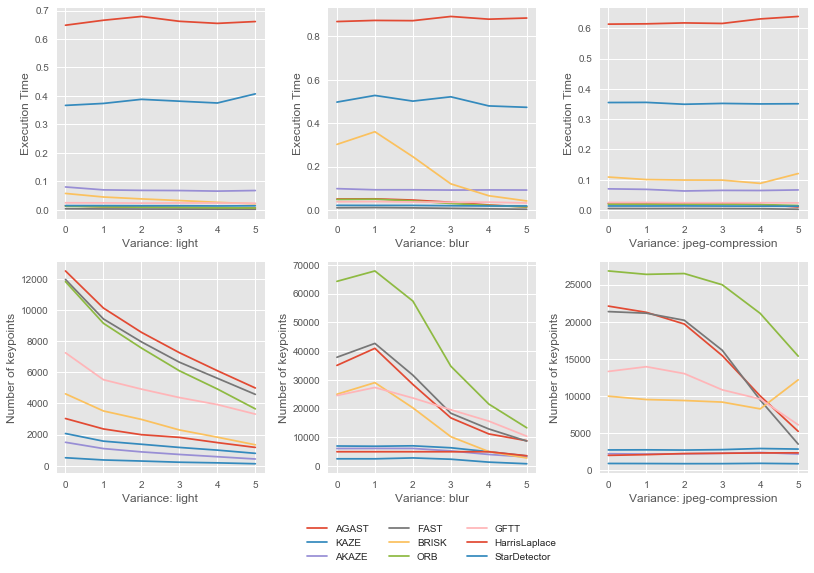

In [123]:
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 3, figsize=(12,8))
axs_col = 0
for plot_data in plot_data_arr:
    for detector_name in dd.get_all_detectors().keys(): 
        execution_time, total_keypoints = plot_data[detector_name]
        axs[0, axs_col].plot(list(execution_time.keys()), list(execution_time.values()), label=detector_name)
        axs[1, axs_col].plot(list(total_keypoints.keys()), [len(value) for value in total_keypoints.values()], label=detector_name)
#     axs[0, axs_col].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    variance = image_set_variance[image_set_arr[axs_col]]
    axs[0, axs_col].set_xlabel(f'Variance: {variance}')
    axs[0, axs_col].set_ylabel("Execution Time")
    
#     axs[1, axs_col].legend(loc="upper center",bbox_to_anchor=(0.5, -0.15), ncol=3)
    axs[1, axs_col].set_xlabel(f'Variance: {variance}')
    axs[1, axs_col].set_ylabel("Number of keypoints")
    axs_col += 1
#     print(image_set_name)
handles, labels = axs[0, 0].get_legend_handles_labels()
plt.legend(handles, labels, loc="upper center",bbox_to_anchor=(-0.8, -0.2), ncol = 3)
fig.subplots_adjust(wspace = 0.3)
plt.show()

#### Gradual darkenning
__Todo__

- [ ] Change to bar plot
- [ ] Ask in stackoverflow about this checkbox problem

In [33]:
image_set_name = 'leuven'
image_set_ = util.get_image_set(pckl_path, image_set_name)
image_num = 4
image = image_set_['{0}_img{1}'.format(image_set_name, image_num)]
df = ex.experiment_1_df(image)
df.style. \
    apply(util.highlight_max, subset=['Execution Time', 'Number of Keypoints']). \
    apply(util.highlight_min, subset=['Execution Time', 'Number of Keypoints'])

,Detector,Execution Time,Number of Keypoints
0,AGAST,0.008240,7263
1,KAZE,0.355294,1174
2,AKAZE,0.072886,723
3,FAST,0.002278,6651
4,BRISK,0.032308,2298
5,ORB,0.008436,6100
6,GFTT,0.023792,4379
7,HarrisLaplace,0.654008,1821
8,StarDetector,0.013486,224


#### Use set to find the intersection of the keypoints to the union

In [17]:

image_set = get_image_set('bikes')
image = image_set['bikes_img1']

execution_time, total_keypoints = get_exec_time_keypoints(image)
union_keypoints = set()
union_keypoints.update(*total_keypoints.values())
# union_keypoints = *union_keypoints.pt
# print(len(all_keypoints))

NameError: name 'get_image_set' is not defined

__TODO__
- [ ] Find intersection
- [ ] Graph frequncy in seaborn
- [ ] List to numpy

In [ ]:
from itertools import chain
# def kp_obj2np(all_keypoints):
#     kp_np = dict()
#     for detector, keypoints in all_keypoints.items():
#         keypoints_to_list = list()
#         for keypoint in keypoints:
#             pt = (round(keypoint.pt[0]), round(keypoint.pt[1]))
#             keypoints_to_list.append(pt)
#         kp_np[detector] = np.array(keypoints_to_list)
#         # keypoints_to_list.clear()
#     return kp_np
kp_np = data.kp_obj2np(total_keypoints)
kp_all = np.array(list(chain(*[value.tolist() for value in kp_np.values()])))
kp_all = np.unique(kp_all, axis=0)
# b = list(chain(*[value.tolist() for value in kp_np.values()]))
# a = set([tuple(el) for el in b])
# a.update(b)
# print(len(a))
print(kp_all.shape)
# print(union_keypoints)

In [ ]:
# keypoint_list = list(union_keypoints)
# print(keypoint_list )
point_freq = np.zeros((kp_all.shape[0],1))
for i in range(0, kp_all.shape[0]):
    for detector in dd.get_all_detectors().keys():
        if kp_all[i] in kp_np[detector]:
            point_freq[i] += 1
print(point_freq)

In [ ]:
kp = np.hstack((kp_all, point_freq))
print(kp)
# plt.imshow(image)
# plt.show()

In [ ]:
max(point_freq)

In [ ]:
# plt.plot(range(0, len(point_freq)), point_freq)
# sns.relplot(x="total_bill", y="tip", data=[range(0, len(point_freq)), point_freq])
sns.set()
plt.scatter([x for (x,y) in keypoint_list], [700-y for (x,y) in keypoint_list], s=point_freq)
plt.show()

In [ ]:
intersection_keypoints = union_keypoints
for detector_name, keypoints in total_keypoints.items():
    print(detector_name)
    keypoints = set()
    keypoints.update(total_keypoints[detector_name])
    intersection_keypoints.intersection_update(keypoints)
    keypoints.clear()
print(len(intersection_keypoints))

In [ ]:
def get_exec_time_keypoints(img):
    keypoints_by_detector = dict()
    execution_time = dict()
    all_detectors = dd.get_all_detectors()

    for name, _ in all_detectors.items():
        detector = dd.initialize_detector(name)
        start_time = default_timer()
        keypoints = detector.detect(img)
        execution_time[name] = default_timer() - start_time
        keypoints_by_detector[name] = keypoints
    return execution_time, keypoints_by_detector

In [ ]:
df = pd.DataFrame() 
df['Detector'] = plot_data.keys()
df['Execution Time'] = [values[0] for values in plot_data.values()]
df['Number of Keypoints'] = [values[1] for values in plot_data.values()]
# df=df.sort_values(by=['Execution Time'])
df.style.\
    apply(highlight_max, subset=['Execution Time', 'Number of Keypoints']).\
    apply(highlight_min, subset=['Execution Time', 'Number of Keypoints'])

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
i = 0
for key, values in key_points_by_detector.items():
    pts = np.asarray([[p.pt[0], p.pt[1]] for p in values])
    x = pts[:,0]
    y = pts[:,1]
    axs[i//3, i%3].set_title(key)
    axs[i//3, i%3].imshow(img)
    axs[i//3, i%3].scatter(x, y, c='r', s=2)
    i += 1
plt.show()